# HEXTOF-processor binning procedure tutorial

This notebook is an example of how to use the hextof-processor to process raw data from the FLASH DAQ raw data format, into binned arrays. These can then be used for analysis with the users favourite tools.

The procedure described here is divided in two sections. First, a direct binning in the raw data axis is presented. The second includes calibration of Binding Energy and pump-probe time delay axes and allows binning in the desired physical quantities.

This guide is intended to be used with the example raw data provided in this repository, and should be run from its original location.


## 0. Imports
Import required libraries

In [2]:
import sys, os
from datetime import datetime
from tqdm.notebook import tnrange

# import numeric packages
import numpy as np
import xarray as xr
import dask
from dask.diagnostics import ProgressBar

# plotting packages
import matplotlib.pyplot as plt

# invoke interactive matplotlib plots
%matplotlib notebook
%matplotlib inline 

# hextof-processor imports
sys.path.append(os.path.dirname(os.getcwd()) ) # add hextof-processor to path
from processor.DldFlashDataframeCreator import DldFlashProcessor
from processor.utilities import calibration, diagnostics, misc, io, vis

### 1. Read raw data and generate single event dataframe

In [5]:
prc = DldFlashProcessor()
# load the correct configuration for the dataset you want to read.
# This can be different for each beamtime.
prc.load_settings('tutorial') 
prc.DATA_RAW_DIR = '../tutorial/raw' # manually overwrite data folder to use the tutorial dataset
prc.DATA_PARQUET_DIR = '../tutorial/parquet' # manually overwrite parquet data folder. it is STRONGLY recomendend to use an SSD drive here.
prc.runNumber = 22097 # run number of the example data given for this tutorial
prc.readData() # read the raw data and generate the single event tables
prc.storeDataframes() # store the single event tables as parquet files.    



Loaded settings from tutorial.ini
loading data...
Reading DAQ data from run 22097... Please wait...
Run 22097
Macrobunches: 7,064  from 99,007,477 to 99,014,541 
Total electrons: 6,970,556, electrons/Macrobunch 986
Generating metadata...
...done!
Creating dataframes... Please wait...
[########################################] | 100% Completed | 20.0s
Electron dataframe created.
Microbunch dataframe created.
Reading Complete.
Creating parquet container ../tutorial/parquetrun22097
[########################################] | 100% Completed |  8.1s
[########################################] | 100% Completed |  1.3s


At this point, the prc object can be re-created using the fresh parquet dataset only. This improves memory efficiency of the overall code. However, generating the parquet intermediate format is not mandatory, and binning can be performed, on small runs, also on the raw data loaded in memory.



In [7]:
# **OPTIONAL** clear memory and load the single event tables from parquet:
prc = DldFlashProcessor() # overwrite the processor with a fresh new instance
prc.runNumber = 22097
prc.DATA_PARQUET_DIR = '../tutorial/parquet' # manually overwrite parquet data folder. it is STRONGLY recomendend to use an SSD drive here.
prc.readDataframes() # load data from single event tables saved as parquet

Searching for parquet data from run22097...
Run 22097
Macrobunches: 7,064  from 99,007,477 to 99,014,541 
Total electrons: 6,970,556, electrons/Macrobunch 986
Loading complete.


## 2. Basic binning

### 2.1 define binning range

In [8]:
# Time of flight parameters
tof_from = 620#180
tof_to = 660
tof_step = 0.003 # the bigger number between this and the original step size is used in the final binning size definition.

# pump-probe delay parameters
delay_from = -517
delay_to = -512.5
delay_step = 0.05

# detector position parameters, valid both in x and y directions
dld_from=0
dld_to=3000
dld_step=30

In [5]:
def timing(cores, method):
    prc.N_CORES = cores
    prc.resetBins() # ensure there is no previous binning axes assigned.
    # prc.addBinning('dldTime', tof_from,tof_to,tof_step, method = method);
    # prc.addBinning('delayStage',delay_from,delay_to,delay_step, method = method);
    prc.addBinning('dldPosX',dld_from,dld_to,dld_step, method = method);
    prc.addBinning('dldPosY',dld_from,dld_to,dld_step, method = method);
    prc.computeBinnedData(method = method, usePbar=False)

In [39]:
boost_times_dldPosXY = %timeit -o timing(5, 'boost')

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
1.74 s ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
numpy_times_dldPosXY = %timeit -o timing(5, 'numpy')

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
1.83 s ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [43]:
boost_times_dldPosXY_delay = %timeit -o timing(5, 'boost')

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
2.61 s ± 49.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
numpy_times_dldPosXY_delay = %timeit -o timing(5, 'numpy')

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
2.25 s ± 34.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
numpy_times = []
for i in [1, 5, 10, 20]:
    numpy_time =  %timeit -o timing(i, 'numpy')
    numpy_times.append(numpy_time)

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
3.97 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating me

In [7]:
numpy_times

[<TimeitResult : 3.97 s ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.94 s ± 50.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.92 s ± 37.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 2.03 s ± 38.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>]

In [8]:
boost_times = []
for i in [1, 5, 10, 20]:
    boost_time =  %timeit -o timing(i, 'boost')
    boost_times.append(boost_time)

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
3.52 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'
Failed creating me

In [9]:
boost_times

[<TimeitResult : 3.52 s ± 131 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.79 s ± 19.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 1.83 s ± 10.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>,
 <TimeitResult : 2.02 s ± 91.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>]

In [22]:
boost_y = []
boost_z = []
numpy_y = []
numpy_z = []
for i in range(len(boost_times)):
    boost_y.append(boost_times[i].best)
    boost_z.append(boost_times[i].stdev)
    numpy_y.append(numpy_times[i].best)
    numpy_z.append(numpy_times[i].stdev)


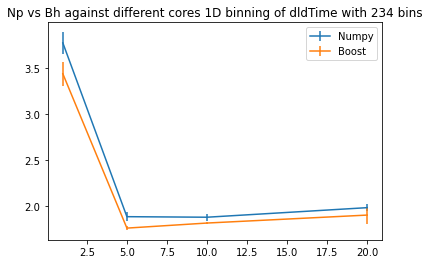

In [30]:
plt.figure()
plt.errorbar([1, 5, 10, 20], numpy_y, numpy_z, label = 'Numpy')
plt.errorbar([1, 5, 10, 20], boost_y, boost_z, label = 'Boost')
plt.legend()
plt.title("Np vs Bh against different cores 1D binning of dldTime with 234 bins")
plt.savefig("1D_lib_comparison.png", format="png")
# plt.show()


In [13]:
def test_results(method):
    prc.resetBins() # ensure there is no previous binning axes assigned.
    prc.addBinning('dldTime', tof_from,tof_to,tof_step, method = method);
    # prc.addBinning('delayStage',delay_from,delay_to,delay_step, method = method);
    # prc.addBinning('dldPosX',dld_from,dld_to,dld_step, method = method);
    # prc.addBinning('dldPosY',dld_from,dld_to,dld_step, method = method);
    result = prc.computeBinnedData(method = method, usePbar=False)
    return result

In [10]:
from numpy.testing import assert_array_equal
# Using dldPosX and Y
assert_array_equal(test_results('numpy'), test_results('boost'))

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'


AssertionError: 
Arrays are not equal

Mismatched elements: 2 / 10000 (0.02%)
Max absolute difference: 2.
Max relative difference: 0.
 x: array([[0., 0., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 4., 2., 2.],
       [0., 0., 2., ..., 0., 0., 2.],...
 y: array([[0., 0., 0., ..., 4., 0., 0.],
       [0., 0., 0., ..., 4., 2., 2.],
       [0., 0., 2., ..., 0., 0., 2.],...

In [14]:
assert_array_equal(test_results('numpy'), test_results('boost'))

Failed creating metadata: 'forced to skip metadata creation'
Failed creating metadata: 'forced to skip metadata creation'


AssertionError: 
Arrays are not equal

Mismatched elements: 1 / 729 (0.137%)
Max absolute difference: 144.
Max relative difference: 0.1540107
 x: array([ 528.,  530.,  505.,  516.,  500.,  475.,  506.,  536.,  532.,
        482.,  473.,  486.,  501.,  478.,  428.,  534.,  530.,  506.,
        493.,  564.,  537.,  417.,  519.,  510.,  456.,  561.,  488.,...
 y: array([ 528.,  530.,  505.,  516.,  500.,  475.,  506.,  536.,  532.,
        482.,  473.,  486.,  501.,  478.,  428.,  534.,  530.,  506.,
        493.,  564.,  537.,  417.,  519.,  510.,  456.,  561.,  488.,...